# Bayesian filtering: tracking multiple objects

## Create the data structures

Load the libraries we need

In [1]:
import math
import time
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

Define the state variables $\mathbf{X}$ and the sensor variables $\mathbf{Y}$. In this case, the state variables consist of the positions of the objects in two dimensions (denoted $h$ and $v$ to avoid confusion with $\mathbf{X}$ and $\mathbf{Y}$) and the sensor variables are the distances to the objects measured by sensors in the four corners of a square: lower left, upper left, lower right, and upper right.

In [2]:
num_objects = 3

dimension_names = [
    'h',
    'v'
]

dimension_names_long = [
    '$h$',
    '$v$'
]

num_dimensions = len(dimension_names)

fixed_sensor_names = [
    'LL',
    'LR',
    'UL',
    'UR'
]

fixed_sensor_names_long = [
    'lower left',
    'lower right',
    'upper left',
    'upper right'
]

num_fixed_sensors = len(fixed_sensor_names)

x_names = []
x_names_long = []

for object_index in range(num_objects):
    for dimension_index in range(num_dimensions):
        x_names.append('obj_{:02d}_pos_{}'.format(object_index + 1,
                                                   dimension_names[dimension_index]))
        x_names_long.append('Object {} {} position'.format(object_index + 1,
                                                           dimension_names_long[dimension_index]))

y_names = []
y_names_long = []

for sending_object_index in range(num_objects):
    receiving_object_range = range(num_objects)
    del receiving_object_range[sending_object_index]
    for receiving_object_index in receiving_object_range:
        y_names.append('obj{:02d}_obj{:02d}_dist'.format(sending_object_index + 1, receiving_object_index + 1))
        y_names_long.append('Object {} distance to object {}'.format(sending_object_index + 1, receiving_object_index + 1))        

for object_index in range(num_objects):
    for sensor_index in range(num_fixed_sensors):
        y_names.append('obj{:02d}_{}_dist'.format(object_index + 1, fixed_sensor_names[sensor_index]))
        y_names_long.append('Object {} distance to {} fixed sensor'.format(object_index + 1, fixed_sensor_names[sensor_index]))

In [3]:
x_names

['obj_01_pos_h',
 'obj_01_pos_v',
 'obj_02_pos_h',
 'obj_02_pos_v',
 'obj_03_pos_h',
 'obj_03_pos_v']

In [4]:
x_names_long

['Object 1 $h$ position',
 'Object 1 $v$ position',
 'Object 2 $h$ position',
 'Object 2 $v$ position',
 'Object 3 $h$ position',
 'Object 3 $v$ position']

In [5]:
y_names

['obj01_obj02_dist',
 'obj01_obj03_dist',
 'obj02_obj01_dist',
 'obj02_obj03_dist',
 'obj03_obj01_dist',
 'obj03_obj02_dist',
 'obj01_LL_dist',
 'obj01_LR_dist',
 'obj01_UL_dist',
 'obj01_UR_dist',
 'obj02_LL_dist',
 'obj02_LR_dist',
 'obj02_UL_dist',
 'obj02_UR_dist',
 'obj03_LL_dist',
 'obj03_LR_dist',
 'obj03_UL_dist',
 'obj03_UR_dist']

In [6]:
y_names_long

['Object 1 distance to object 2',
 'Object 1 distance to object 3',
 'Object 2 distance to object 1',
 'Object 2 distance to object 3',
 'Object 3 distance to object 1',
 'Object 3 distance to object 2',
 'Object 1 distance to LL fixed sensor',
 'Object 1 distance to LR fixed sensor',
 'Object 1 distance to UL fixed sensor',
 'Object 1 distance to UR fixed sensor',
 'Object 2 distance to LL fixed sensor',
 'Object 2 distance to LR fixed sensor',
 'Object 2 distance to UL fixed sensor',
 'Object 2 distance to UR fixed sensor',
 'Object 3 distance to LL fixed sensor',
 'Object 3 distance to LR fixed sensor',
 'Object 3 distance to UL fixed sensor',
 'Object 3 distance to UR fixed sensor']

In [7]:
num_x_vars = len(x_names)
num_y_vars = len(y_names)

## Create the core probability models

The particle filter takes three core probability models as inputs: the initial state $f(\mathbf{X}_0)$, the transition model $f(\mathbf{X}_t | \mathbf{X}_{t-1})$, and the sensor response model $f(\mathbf{Y} | \mathbf{X})$. In this case, we define the room as a rectangle which is 2 units wide and 1 unit high. The initial positions of the objects are distributed uniformly within the room. The transition model is a two-dimensional random walk for each object with a standard deviation of $\sigma_t = 0.1$. The sensor response model is that the sensors are placed in the corners of the room and they measure the distances to the objects with Gaussian error $\sigma_m = 0.2$.

In [8]:
room_size = np.array([2.0, 1.0])
drift = 0.1
fixed_sensor_positions = np.array([
    [0.0, 0.0],
    [room_size[0], 0.0],
    [0.0, room_size[1]],
    [room_size[0], room_size[1]]
])
sensor_error = 0.2

In [9]:
fixed_sensor_positions

array([[ 0.,  0.],
       [ 2.,  0.],
       [ 0.,  1.],
       [ 2.,  1.]])

### Initial state

Define a function that generates samples of the initial state $\mathbf{X}_0$. We'll need this both to generate our simulated data and as an input to the particle filter.

In [10]:
def x_initial_sample():
    return np.random.uniform(high=np.tile(room_size, num_objects))

Generate 1,000 samples and check that they have the properties we expect.

In [11]:
time_start = time.clock()
x_initial_samples = np.array([x_initial_sample() for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0272912950224


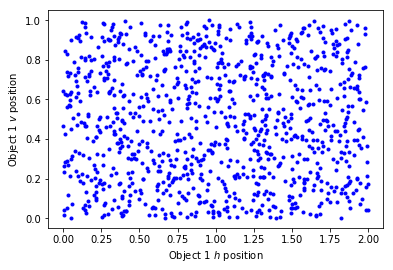

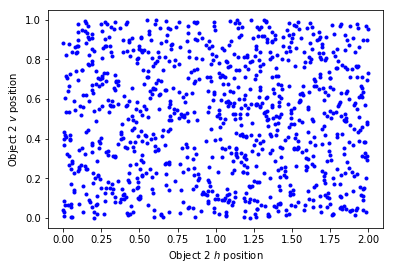

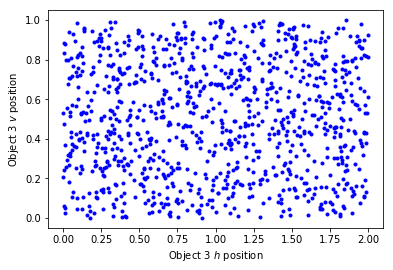

In [12]:
for object_index in range(num_objects):
    plt.plot(x_initial_samples[:,object_index*2],
             x_initial_samples[:,object_index*2 + 1], 'b.')
    plt.xlabel(x_names_long[object_index*2])
    plt.ylabel(x_names_long[object_index*2 + 1])
    plt.show()

Calculate the means of the initial positions.

In [13]:
np.mean(x_initial_samples, 0)

array([ 0.99442515,  0.48884454,  1.01759409,  0.50042687,  0.99106466,
        0.50593832])

Compare with the known mean of the uniform distribution.

In [14]:
room_size/2

array([ 1. ,  0.5])

Calculate the standard deviations of the initial positions.

In [15]:
np.std(x_initial_samples, 0)

array([ 0.5662776 ,  0.29180999,  0.58325336,  0.29514933,  0.58137041,
        0.28114239])

Compare with the known standard deviation of the uniform distribution.

In [16]:
room_size/math.sqrt(12)

array([ 0.57735027,  0.28867513])

### Transition model

Define a function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$. We'll use this both to generate our simulated data and as an input to the particle filter.

In [17]:
x_bar_x_prev_covariance = np.diagflat(np.repeat(drift**2,num_objects*num_dimensions))

In [18]:
def x_bar_x_prev_sample(x_prev):
    return np.random.multivariate_normal(x_prev, x_bar_x_prev_covariance)

Choose an arbitrary test value for $\mathbf{X}$ that we can use to test the various functions. Place one object in the lower-left corner, one in the upper-right corner, and one in the middle.

In [19]:
test_x_value = np.array([0, 0, room_size[0], room_size[1], room_size[0]/2, room_size[1]/2])

Generate 1,000 samples (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [20]:
time_start = time.clock()
x_bar_x_prev_samples = np.array([x_bar_x_prev_sample(test_x_value) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.158120039202


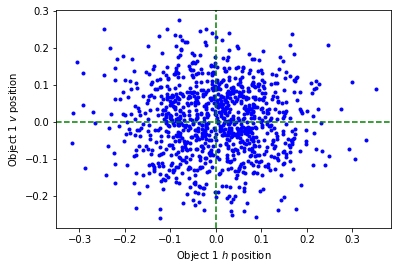

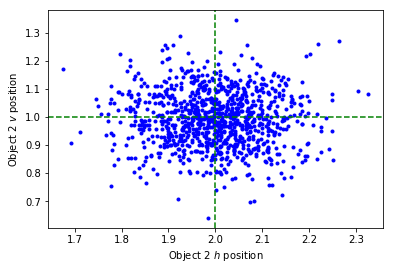

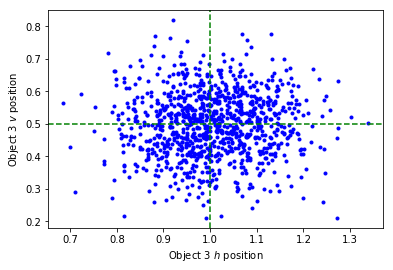

In [21]:
for object_index in range(num_objects):
    plt.plot(x_bar_x_prev_samples[:,object_index*2],
             x_bar_x_prev_samples[:,object_index*2 + 1], 'b.')
    plt.xlabel(x_names_long[object_index*2])
    plt.ylabel(x_names_long[object_index*2 + 1])
    plt.axvline(x=test_x_value[object_index*2], linestyle='dashed', color='green')
    plt.axhline(y=test_x_value[object_index*2 + 1], linestyle='dashed', color='green')
    plt.show()

Calculate the means of the samples.

In [22]:
np.mean(x_bar_x_prev_samples, 0)

array([-0.0023252 ,  0.00416614,  1.99855472,  0.99287828,  1.00375267,
        0.49714567])

Compare with $\mathbf{X}_{t-1}$.

In [23]:
test_x_value

array([ 0. ,  0. ,  2. ,  1. ,  1. ,  0.5])

Calculate the standard deviations of the samples.

In [24]:
np.std(x_bar_x_prev_samples, 0)

array([ 0.10330002,  0.09848463,  0.09843471,  0.09828708,  0.10119406,
        0.09917646])

Compare with the drift of the random walk.

In [25]:
drift

0.1

### Sensor response model

Define a function that returns the distances between the different objects (in the same order as `y_names` above) given $\mathbf{x}$.

In [26]:
def distances_between_objects(x):
    return np.delete(np.linalg.norm(np.subtract(np.tile(x.reshape((num_objects, num_dimensions)),
                                                        (num_objects,1)),
                                                np.repeat(x.reshape((num_objects, num_dimensions)),
                                                          num_objects,
                                                          axis=0)),
                                    axis=1),
                     np.arange(num_objects)*num_objects + np.arange(num_objects))    

Try this function for our test $\mathbf{X}$ value to make sure we get the results we expect.

In [27]:
distances_between_objects(test_x_value)

array([ 2.23606798,  1.11803399,  2.23606798,  1.11803399,  1.11803399,
        1.11803399])

Define a function that returns the distances from the objects to the fixed sensors (in the same order as `y_names`) given $\mathbf{X}$.

In [28]:
def distances_to_fixed_sensors(x):
    return np.linalg.norm(np.subtract(np.repeat(x.reshape((num_objects, num_dimensions)), num_fixed_sensors, axis=0),
                                      np.tile(fixed_sensor_positions, (num_objects,1))),
                          axis=1)

Try this function out for our test $\mathbf{X}$ value to make sure we get the results we expect.

In [29]:
distances_to_fixed_sensors(test_x_value)

array([ 0.        ,  2.        ,  1.        ,  2.23606798,  2.23606798,
        1.        ,  2.        ,  0.        ,  1.11803399,  1.11803399,
        1.11803399,  1.11803399])

Compare results above with the distance between the opposite corners of the room.

In [30]:
math.sqrt(room_size[0]**2 + room_size[1]**2)

2.23606797749979

Compare results above with the distance from the center of the room to the corners.

In [31]:
math.sqrt((room_size[0]/2)**2+ (room_size[1]/2)**2)

1.118033988749895

Combine these two functions into a function that returns all of the measured distances (in the same order as `y_names`), given $\mathbf{X}$.

In [32]:
def distances(x):
    return np.concatenate((distances_between_objects(x), distances_to_fixed_sensors(x)))

Try this function out for our test $\mathbf{X}$ value to make sure we get the results we expect.

In [33]:
distances(test_x_value)

array([ 2.23606798,  1.11803399,  2.23606798,  1.11803399,  1.11803399,
        1.11803399,  0.        ,  2.        ,  1.        ,  2.23606798,
        2.23606798,  1.        ,  2.        ,  0.        ,  1.11803399,
        1.11803399,  1.11803399,  1.11803399])

Using this function, define the function that generates samples of the sensor readings $\mathbf{Y}$ given $\mathbf{X}$. We'll use this to generate our simulated data.

In [34]:
y_bar_x_covariance = np.diagflat(np.repeat(sensor_error**2, num_y_vars))

In [35]:
def y_bar_x_sample(x):
    return np.random.multivariate_normal(distances(x), y_bar_x_covariance)

Generate 1,000 samples (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [36]:
time_start = time.clock()
y_bar_x_samples = np.array([y_bar_x_sample(test_x_value) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.343763479994


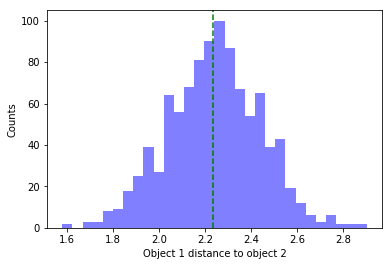

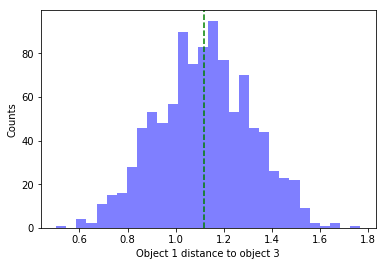

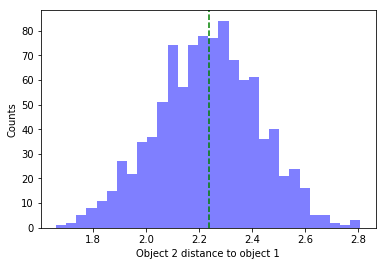

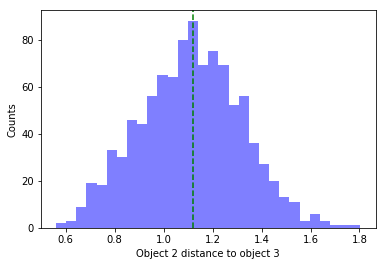

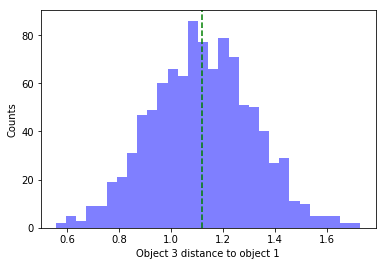

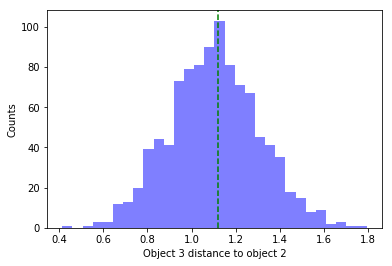

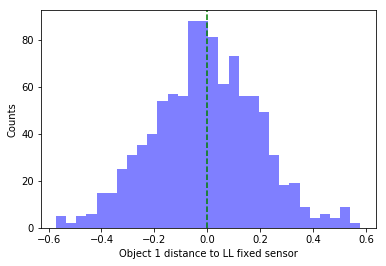

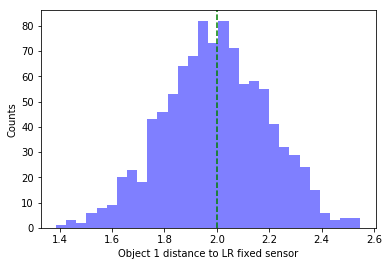

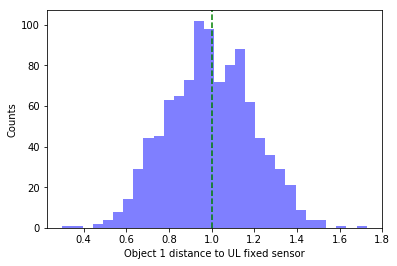

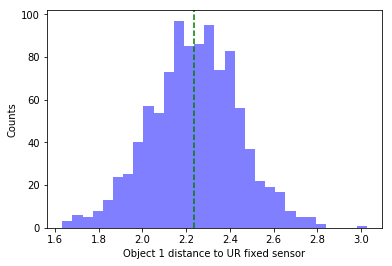

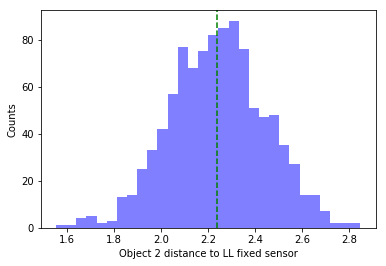

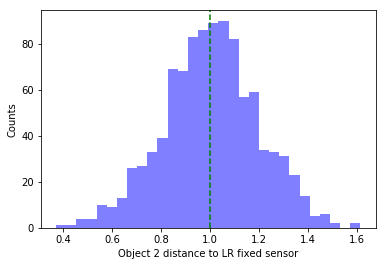

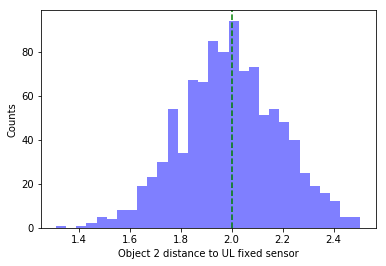

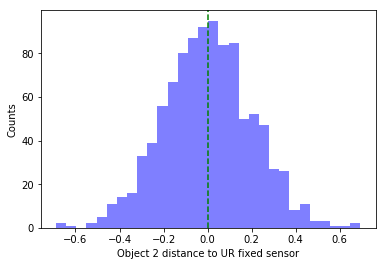

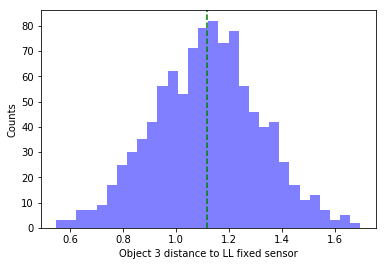

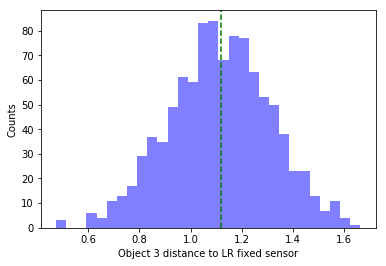

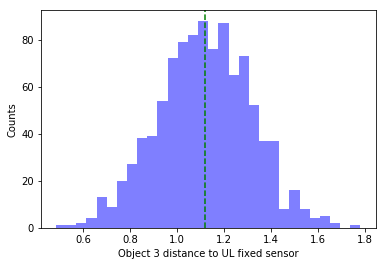

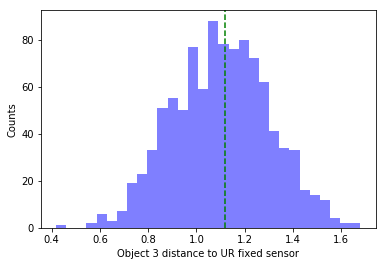

In [37]:
for y_var_index in range(num_y_vars):
    plt.hist(y_bar_x_samples[:,y_var_index], bins=30, facecolor='blue', alpha=0.5)
    plt.xlabel(y_names_long[y_var_index])
    plt.ylabel('Counts')
    plt.axvline(x=distances(test_x_value)[y_var_index], color='green', linestyle='dashed')
    plt.show()

Calculate the means of the samples.

In [38]:
np.mean(y_bar_x_samples, 0)

array([  2.24147967e+00,   1.11812803e+00,   2.23064162e+00,
         1.11131128e+00,   1.12136722e+00,   1.10380917e+00,
        -6.19391482e-03,   1.99632462e+00,   9.93211109e-01,
         2.23888386e+00,   2.23937632e+00,   1.00276877e+00,
         1.99399699e+00,   2.10482534e-03,   1.11607250e+00,
         1.11299371e+00,   1.11727280e+00,   1.10293343e+00])

Compare with the known distances for our test $\mathbf{X}$ value.

In [39]:
distances(test_x_value)

array([ 2.23606798,  1.11803399,  2.23606798,  1.11803399,  1.11803399,
        1.11803399,  0.        ,  2.        ,  1.        ,  2.23606798,
        2.23606798,  1.        ,  2.        ,  0.        ,  1.11803399,
        1.11803399,  1.11803399,  1.11803399])

Calculate the standard deviations of the samples.

In [40]:
np.std(y_bar_x_samples, 0)

array([ 0.2024257 ,  0.19525347,  0.1918316 ,  0.20647175,  0.19697277,
        0.20464417,  0.1981928 ,  0.19943861,  0.201359  ,  0.20378906,
        0.20328474,  0.19402302,  0.19402692,  0.20169409,  0.20003833,
        0.1984668 ,  0.19817251,  0.19960005])

Compare with the defined sensor error.

In [41]:
sensor_error

0.2

Now we need the function $f(\mathbf{Y} | \mathbf{X})$, which returns the probability density for a set of sensor readings given the state of the system. We'll use this as an input to the particle filter. We start by defining a generic Gaussian probability density function. We work with log-probabilities rather than probabilities to prevent underflow problems. We construct the Gaussian distribution from base Python operations rather than use the `scipy` PDF function because the latter was meaningfully slower in our tests.

In [42]:
def log_pdf_gaussian(q, mean, sd):
    return -(q-mean)**2/(2*sd**2) - math.log(math.sqrt(2*math.pi)*sd)

For convenience, define a vectorized version of this function.

In [43]:
log_pdf_gaussian_vectorized = np.vectorize(log_pdf_gaussian)

Plot the generic Gaussian probability distibution function for an arbitrary mean and standard deviation to make sure it has the shape and normalization we expect.

In [44]:
q_range = np.arange(-10.0, 0.0, 0.01)

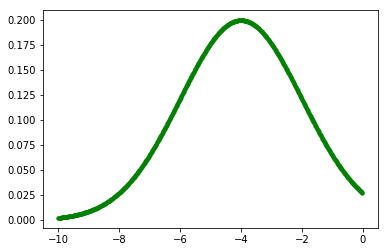

In [45]:
plt.plot(q_range, np.exp(log_pdf_gaussian_vectorized(q_range, -4.0, 2.0)), 'g.')
plt.show()

Using the generic Gaussian, define $\log(f(\mathbf{Y} | \mathbf{X}))$.

In [46]:
def log_f_y_bar_x(x, y):
    return np.sum(log_pdf_gaussian_vectorized(y, distances(x), sensor_error))

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. For each sensor reading, we plot a range from zero distance to the distance between the corners of the room.

In [47]:
distance_range = np.arange(0, np.linalg.norm(room_size), np.linalg.norm(room_size)/500)

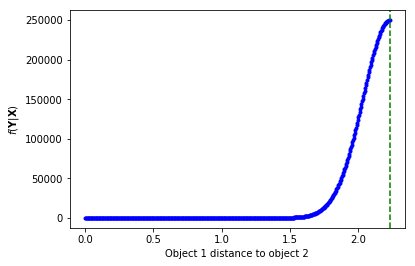

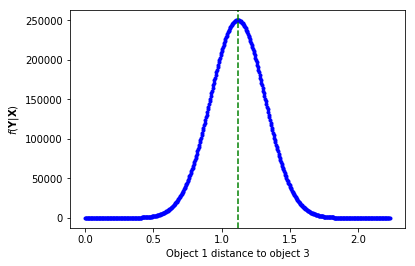

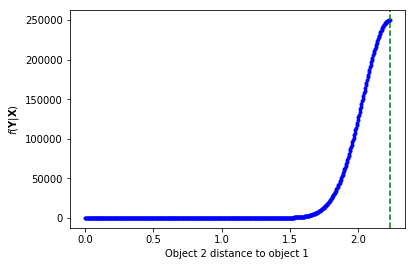

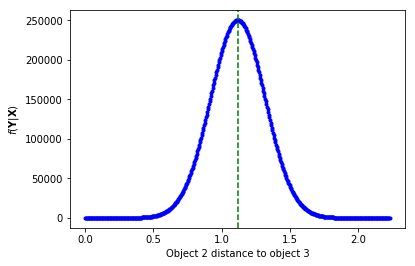

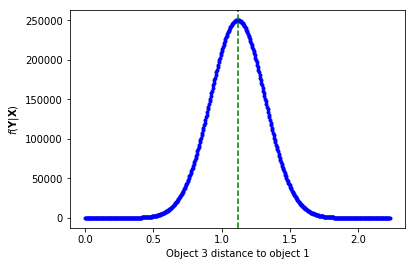

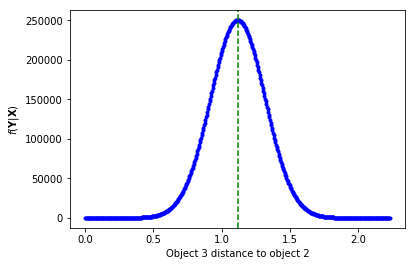

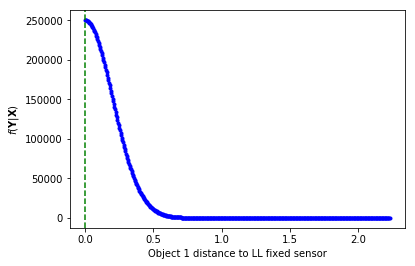

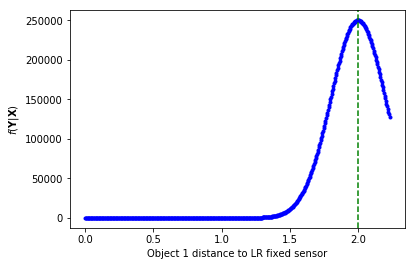

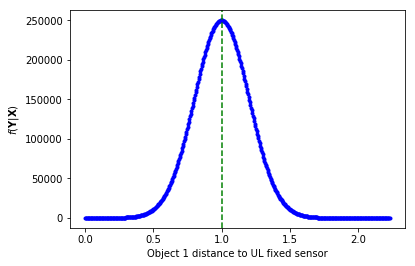

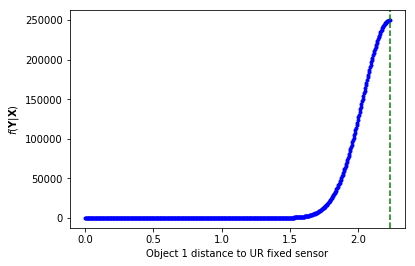

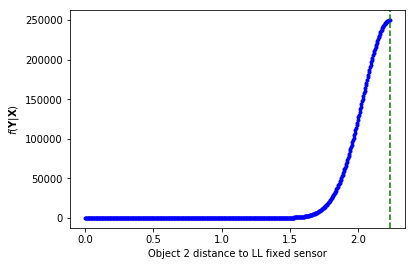

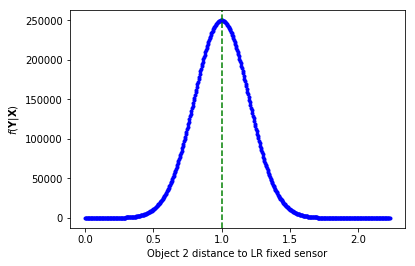

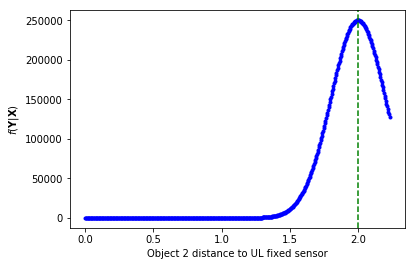

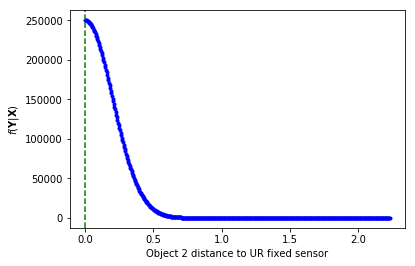

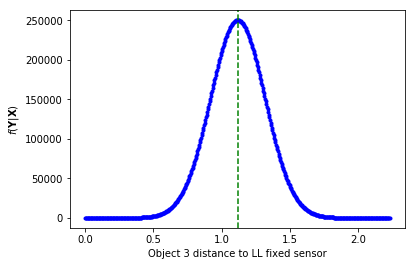

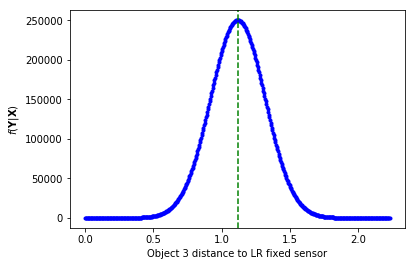

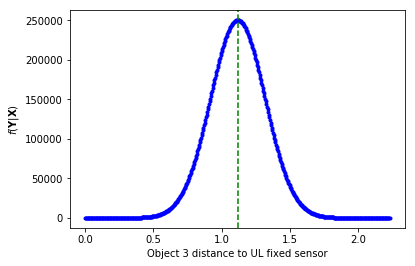

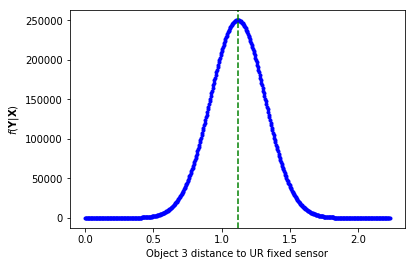

In [48]:
for y_var_index in range(num_y_vars):
    y_range = np.tile(distances(test_x_value), (len(distance_range), 1))
    y_range[:, y_var_index] = distance_range
    log_f_range = np.array([log_f_y_bar_x(test_x_value, y) for y in y_range])
    plt.plot(distance_range, np.exp(log_f_range), 'b.')
    plt.axvline(x=distances(test_x_value)[y_var_index], color='green', linestyle='dashed')
    plt.xlabel(y_names_long[y_var_index])
    plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
    plt.show()    

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Set the number of timesteps and initialize the variables.

In [49]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_t = np.zeros((num_timesteps, num_x_vars), dtype='float')
y_t = np.zeros((num_timesteps, num_y_vars), dtype='float')

Calculate the data for $t=0$.

In [50]:
t[0] = 0.0

In [51]:
x_t[0] = x_initial_sample()

In [52]:
y_t[0] = y_bar_x_sample(x_t[0])

Calculate the data for $t>0$.

In [53]:
timestep_size = 1.0

In [54]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_t[t_index] = x_bar_x_prev_sample(x_t[t_index - 1])
    y_t[t_index] = y_bar_x_sample(x_t[t_index])

Plot the positions of the objects to make sure they have the properties we expect.

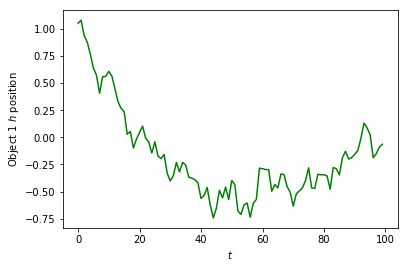

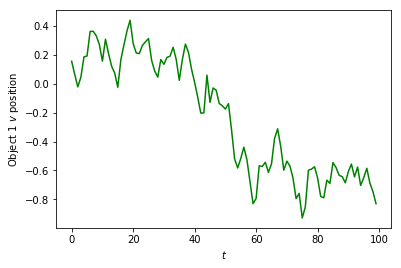

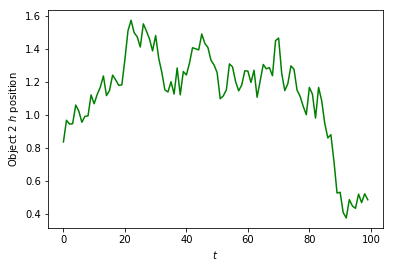

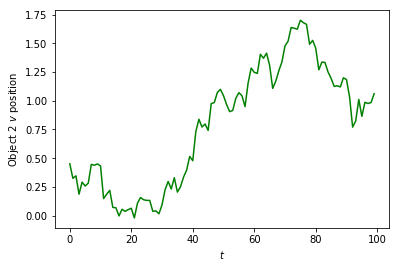

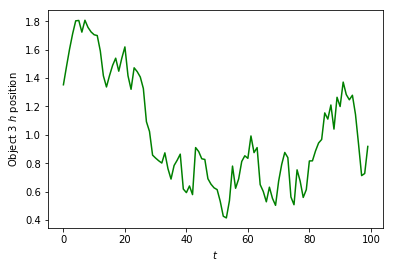

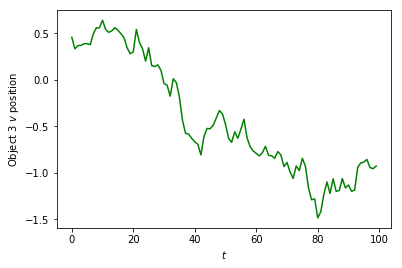

In [55]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:, x_var_index], 'g-')
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()

Plot the sensor readings against the actual distances to the sensors, to make sure they have the properties we expect.

In [56]:
distances_t = np.array([distances(x) for x in x_t])

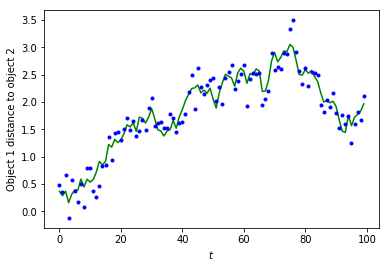

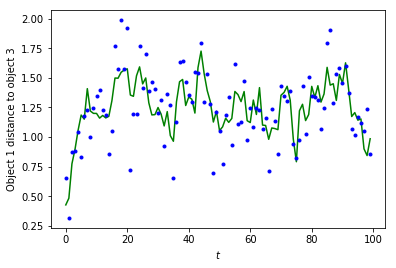

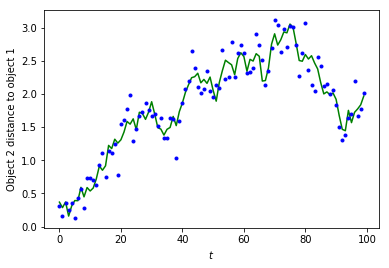

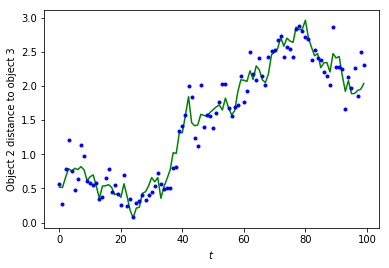

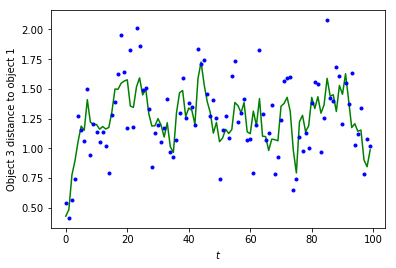

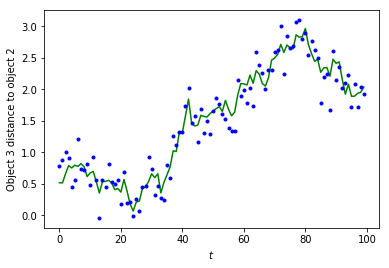

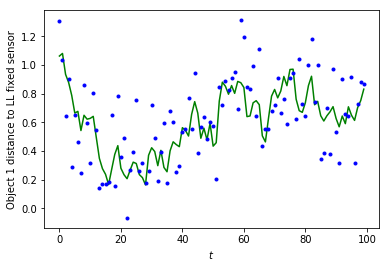

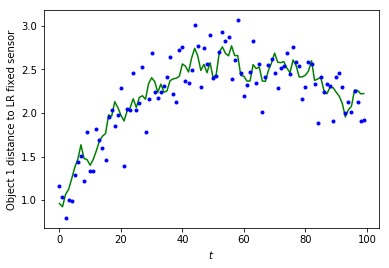

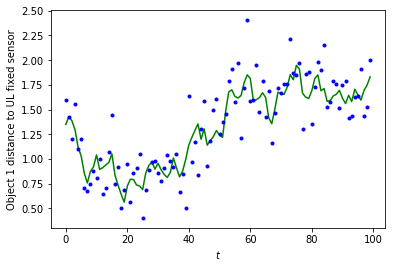

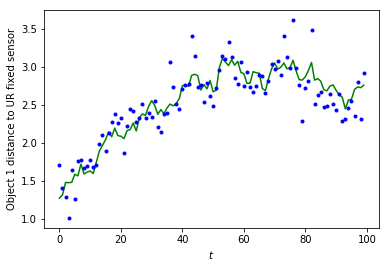

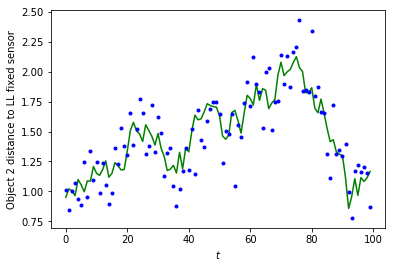

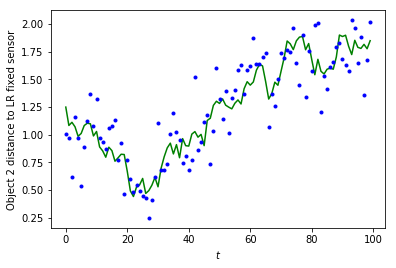

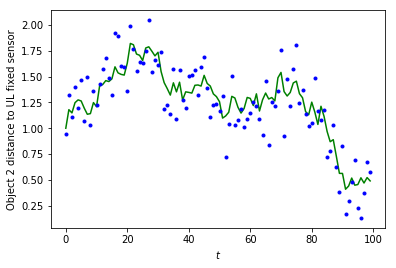

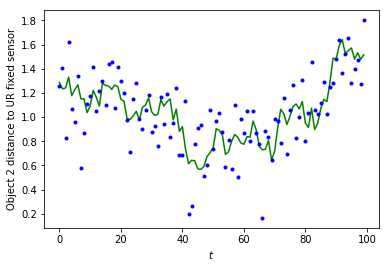

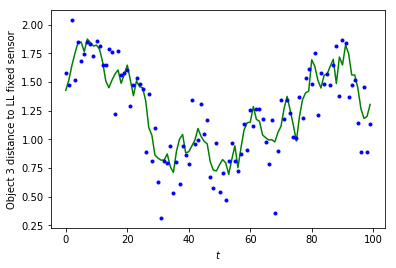

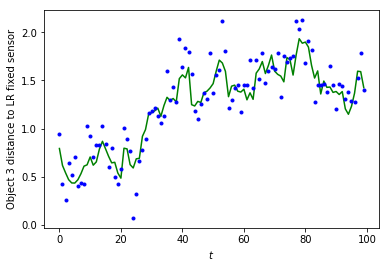

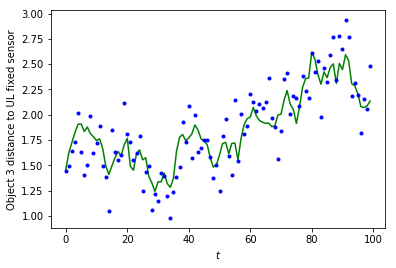

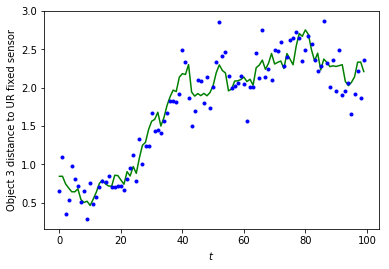

In [57]:
for y_var_index in range(num_y_vars):
    plt.plot(t, distances_t[:, y_var_index], 'g-')
    plt.plot(t, y_t[:, y_var_index], 'b.')
    plt.xlabel('$t$')
    plt.ylabel(y_names_long[y_var_index])
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \mathbf{Y}_1, \ldots, \mathbf{Y}_t)$ using a particle filter

Set the number of particles and initialize variables.

In [58]:
num_particles = 50
particle_values = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
log_particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')

Generate the particles for the initial state $\mathbf{X}_0$.

In [59]:
time_start = time.clock()
for particle_index in range(num_particles):
    particle_values[0, particle_index] = x_initial_sample()
    log_particle_weights[0, particle_index] = log_f_y_bar_x(particle_values[0, particle_index], y_t[0])
log_particle_weights[0] = log_particle_weights[0] - misc.logsumexp(log_particle_weights[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0110647419457


Check to see that these particles have the properties we expect.

In [60]:
math.exp(misc.logsumexp(log_particle_weights[0]))

0.9999999999999999

In [61]:
x_initial_mean = np.average(particle_values[0], axis=0, weights = np.exp(log_particle_weights[0]))

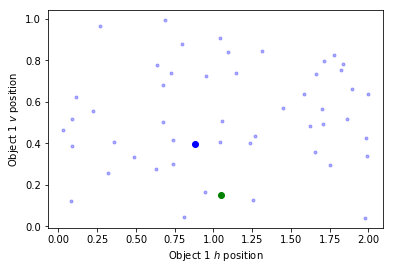

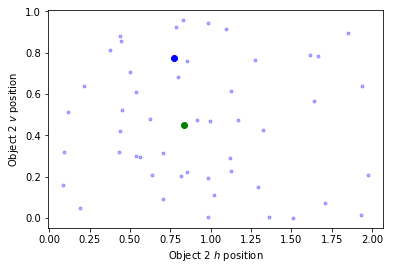

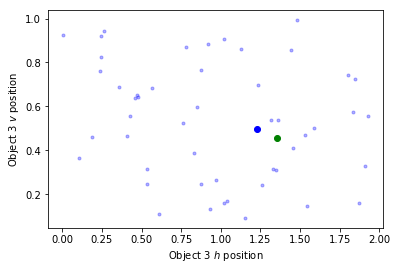

In [62]:
for object_index in range(num_objects):
    plt.plot(x_t[0,object_index*2],x_t[0,object_index*2 + 1],'go')
    plt.plot(x_initial_mean[object_index*2], x_initial_mean[object_index*2 + 1], 'bo')
    plt.plot(particle_values[0,:,object_index*2],particle_values[0,:,object_index*2 + 1], 'b.', alpha=0.3)
    plt.xlabel(x_names_long[object_index*2])
    plt.ylabel(x_names_long[object_index*2 + 1])
    plt.show()

This looks as we expect. For each object, the particles are distributed according to the initial probability distribution (i.e., unform across the room, not according to the actual position of the particle). The weighted means of the particles incorporate the sensor readings and therefore they are closer to the actual positions of the objects, but not precisely on top of them due to both sensor error and sampling error. The real test is whether the particles converge and track the actual state as we generate successive sets of particles.

Calculate the particles for all times $t>0$.

In [63]:
time_start = time.clock()
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values[t_index - 1,
                                            np.random.choice(num_particles,
                                                             p=np.exp(log_particle_weights[t_index - 1]))]
        particle_values[t_index, particle_index] = x_bar_x_prev_sample(previous_particle)
        log_particle_weights[t_index, particle_index] = log_f_y_bar_x(particle_values[t_index, particle_index], y_t[t_index])
    log_particle_weights[t_index] = log_particle_weights[t_index]- misc.logsumexp(log_particle_weights[t_index])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 1.85671558113


Calculate the sample means and sample standard deviations of the particles at each time $t$.

In [64]:
x_mean_particle = np.average(
    particle_values, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), num_x_vars).reshape((num_timesteps, num_particles, num_x_vars))
)

In [65]:
x_squared_mean_particle = np.average(
    np.square(particle_values), 
    axis=1,
    weights=np.repeat(np.exp(log_particle_weights), num_x_vars).reshape((num_timesteps, num_particles, num_x_vars))
)

In [66]:
x_sd_particle = np.sqrt(x_squared_mean_particle - np.square(x_mean_particle))

Plot these sample means of the particles against the actual values of $\mathbf{X}_t$.

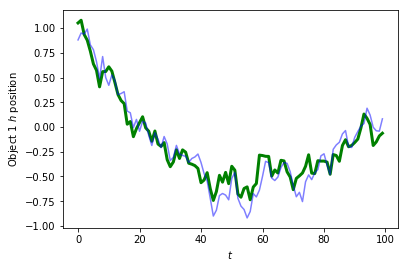

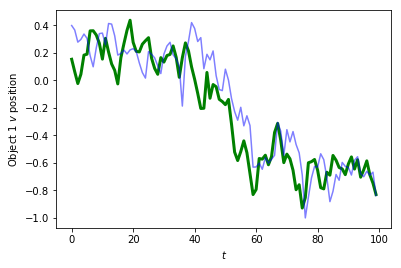

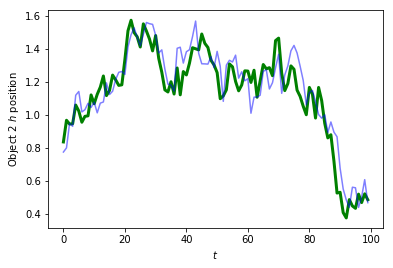

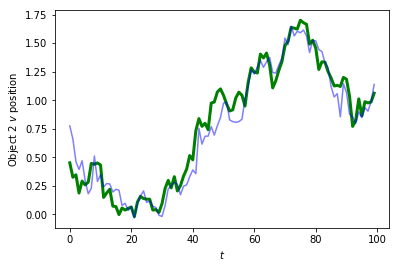

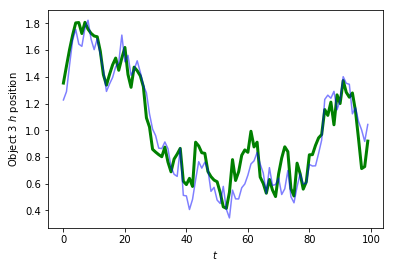

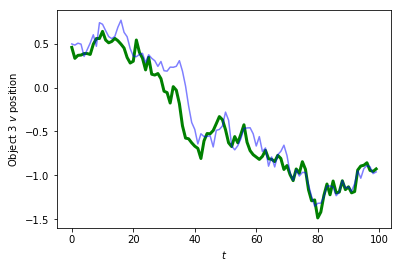

In [67]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0)
    plt.plot(t, x_mean_particle[:,x_var_index], 'b-', alpha=0.5)
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()

Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

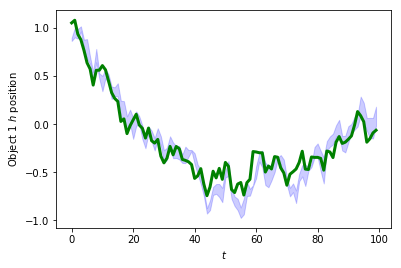

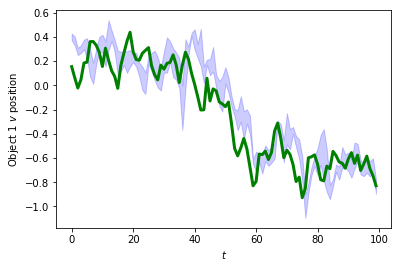

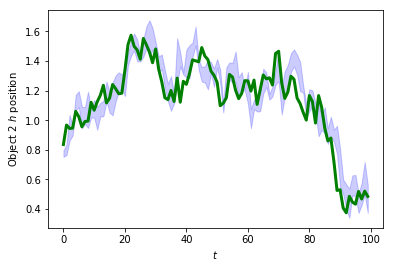

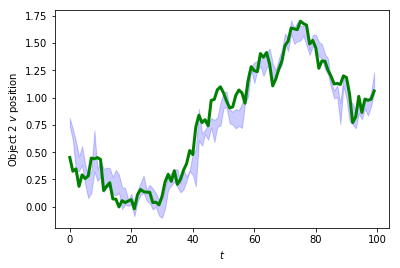

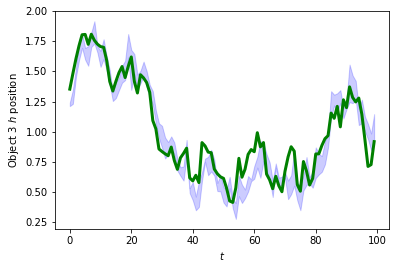

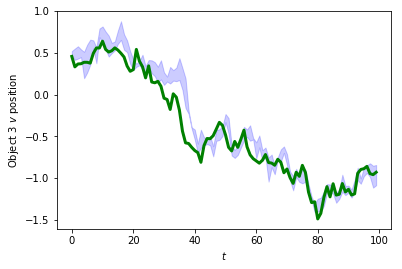

In [68]:
for x_var_index in range(num_x_vars):
    plt.fill_between(
        t,
        x_mean_particle[:,x_var_index] - x_sd_particle[:, x_var_index],
        x_mean_particle[:,x_var_index] + x_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2
    )
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0)
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()


The particle filter tracks extremely well, even with only 50 particles.